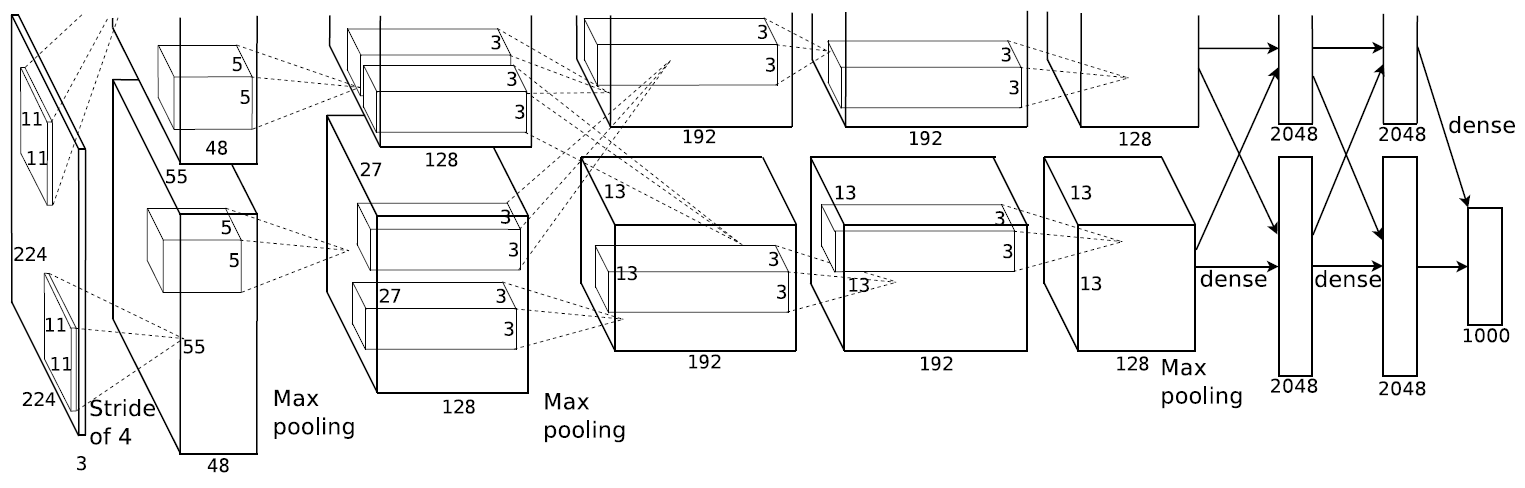

Implementation of Alexnet

Alexnet : ImageNet Classification with Deep Convolutional Neural Networks <br>
https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf

In [47]:
import torch
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from torchsummary import summary

In [48]:
def custom_imshow(img):
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [49]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(227),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


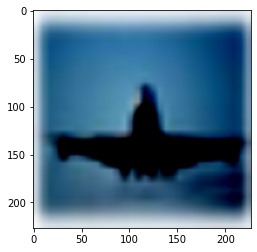

plane


In [50]:
sample_num = 694

custom_imshow(trainset[sample_num][0])
print(classes[trainset[sample_num][1]])

In [51]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [57]:
class Alexnet(torch.nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, 96, kernel_size=11, stride=4),
            torch.nn.ReLU(inplace=True),
            torch.nn.LocalResponseNorm(2),
            torch.nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.LocalResponseNorm(2),
            torch.nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True)
        )
        
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True)
        )
        
        self.layer5 = torch.nn.Sequential(
            torch.nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.avgpool = torch.nn.AdaptiveAvgPool2d((6,6))

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(6*6*256, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, num_classes)
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        
        return self.classifier(x)

In [58]:
model = Alexnet(3, 10).to(device)
summary(model, input_size=(3, 227, 227), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
 LocalResponseNorm-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
              ReLU-6          [-1, 256, 27, 27]               0
 LocalResponseNorm-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]       1,327,488
             ReLU-12          [-1, 384, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         884,992
             ReLU-14          [-1, 256,

In [59]:
lr = 1e-4
epochs = 50

In [60]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
for epoch in range(epochs):
    print("\nEpoch ", epoch)
    # train
    print("\nTrain:")
    model.train()
    train_loss = 0
    for i, (images, targets) in enumerate(train_loader): 
        images, targets = images.to(device), targets.to(device)
        
        pred = model(images)
        loss = F.cross_entropy(pred, targets)    
        
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if ((i+1) % (len(train_loader) // 30) == 1) or i+1 == len(train_loader):
            print('[%3d/%3d] | Loss: %.5f'%(i+1, len(train_loader), train_loss/(i+1)))
    # val
    print("\nValidation")
    model.eval()
    val_loss = 0
    for i, (images, targets) in enumerate(test_loader):
        images, targets = images.to(device), targets.to(device)
        preds = model(images)
        loss = criterion(preds, targets)   
        val_loss += loss.item()

        if ((i+1) % (len(test_loader) // 3) == 1) or i+1 == len(test_loader):
            print('[%3d/%3d] | Loss: %.5f'%(i+1, len(test_loader), val_loss/(i+1)))


Epoch  0

Train:
[  1/12500] | Loss: 2.30548
[417/12500] | Loss: 2.18042
[833/12500] | Loss: 2.10696
[1249/12500] | Loss: 2.03616
[1665/12500] | Loss: 1.97763
[2081/12500] | Loss: 1.92621
[2497/12500] | Loss: 1.87454
[2913/12500] | Loss: 1.83482
[3329/12500] | Loss: 1.79811
[3745/12500] | Loss: 1.76632
[4161/12500] | Loss: 1.73643
[4577/12500] | Loss: 1.71284
[4993/12500] | Loss: 1.68696
[5409/12500] | Loss: 1.66413
[5825/12500] | Loss: 1.64347
[6241/12500] | Loss: 1.62174
[6657/12500] | Loss: 1.60010
[7073/12500] | Loss: 1.58307
[7489/12500] | Loss: 1.56303
[7905/12500] | Loss: 1.54413
[8321/12500] | Loss: 1.52794
[8737/12500] | Loss: 1.51045
[9153/12500] | Loss: 1.49551
[9569/12500] | Loss: 1.48182
[9985/12500] | Loss: 1.46780
[10401/12500] | Loss: 1.45374
[10817/12500] | Loss: 1.44045
[11233/12500] | Loss: 1.42737
[11649/12500] | Loss: 1.41443
[12065/12500] | Loss: 1.40114
[12481/12500] | Loss: 1.39076
[12500/12500] | Loss: 1.39046

Validation
[  1/2500] | Loss: 0.23710
[834/2500] 